In [1]:
import cirq
import numpy as np
import random as rand
import matplotlib.pyplot as plt

from cirq import Circuit
from cirq.devices import GridQubit
from cirq.google import XmonSimulator
from cirq import ops

# Quantum Compression


## Introduction
Goal: Simulate an Ising chain of $n$-qubits, using only $\log n$ qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

We use the following set up in Cirq for the rest of the tutorial:

In [2]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

## Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [3]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───

1: ───────X──────
          │
2: ───H───@──────

## Step 2

Evolve the system up to the desired value of $J$, which in this case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [4]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────
          │
2: ───H───@──────────────────────────────────────────────────

Apply $(THS)^4$ on qubit $0$:

In [5]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────────────────────────────────────────────────────
          │
2: ───H───@──────────────────────────────────────────────────────────────────────────────────────────────────

In [6]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Step 3

Measure $Y$ on qubit $m$ to obtain the magnetization. In this case, $m = \log_{2}(4) - 1 = 1$. By nature of the rotation matrices in the matchgate circuit construction (Jozsa et al.), the $Z$ expectation of qubit $0$ after the circuit has completed $\langle Z_{0} \rangle$ is equal to the $Y$ expectation of qubit $m$ $\langle Y_{m} \rangle$, so a standard basis measurement made. Measuring the state $|0\rangle$ will correspond to an eigenvalue of $+1$ and the state $|1\rangle$ to an eigenvalue of $-1$. The expectation is equal to $\langle Y_{m} \rangle = -M(J)$, the magnetization as a function of $J$ (Hebenstreait et al.).

### Wave Function


Preserve the wave function of the system prior to measurement:

In [7]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [8]:
wave_function

measurements: (no measurements)
output vector: (-0.258-0.393j)|000⟩ + (0.393-0.258j)|001⟩ + (-0.096+0.46j)|010⟩ + (0.46+0.096j)|011⟩ + (-0.133+0.107j)|100⟩ + (-0.107-0.133j)|101⟩ + (0.169+0.018j)|110⟩ + (0.018-0.169j)|111⟩

Calculate the magnetization $M(J)$ from the wave function by decomposing the final state into the $+1$ and $-1$ eigenstates, determining the total probability for each, and computing the expectation $\langle Y_{m} \rangle$:

In [9]:
final_state = wave_function.final_state

p_1_wfn = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_n1_wfn = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

Y_wfn = 1 * p_1_wfn + -1 * p_n1_wfn

M_wfn = -Y_wfn
M_wfn

-0.7683054202225357

# Measured Outcome

Apply the standard basis measurement operator to qubit $0$:

In [10]:
circuit.append([cirq.measure(qubit0, key='x')])
circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───M('x')───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Repeatedly run the circuit for $n=1,000,000$ iterations:

In [11]:
n = 1000000
results = simulator.run(circuit, repetitions=n)
results

x=01001000000000000000000000010100001000010000000100011000000000000000000010000100000001100000000000001000100010000000000000000100000001000001000000000010000000000000010000010000101001001000100010100100001101000000001000000000010010000000001000000010000000000000000000000010000000100000100100000001000000010000000001000011001000000000100000000100001000000000000000000000000000001001100001000000100011000000000000000000000000000000000000000000000000100001000000101000000000000000000100000000000100000010100000000000000000011000100000010000100001001000000001000001101001010011000000000001110000100000000000100000000000100000000100011000000100110010000010000000000000000000000000100000000100000010001000000000100010000000000000110001001000000000000000001011100000000000000000000010000100000000000100001001000000010100000000010000010000000010000001000011000000011001000000000000000000001000000000000100000000000000000101110000000000000000000100000001000001000000000000000010010001000001000000000000000000

Counter({0: 883703, 1: 116297})


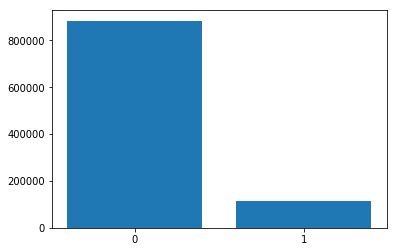

In [12]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

Calculate the magnetization $M(J)$ from the measured outcomes by determining the relative frequency of each eigenstate and computing the expectation $\langle Y_{m} \rangle$:

In [13]:
f_1_meas = hist[0] / n
f_n1_meas = hist[1] / n

Y_meas = 1 * f_1_meas - 1 * f_n1_meas

M_meas = - Y_meas
M_meas

-0.767406

# Final Results
We can now compare our three results: the measured outcomes (finite number of runs), the wave function (limit of infinite runs), and the theoretical prediction given by the Ising model (Hebenstreait et al.):

In [14]:
M_theor = -0.81

err_wfn = 100 * (M_theor - M_wfn) / M_theor
err_meas = 100 * (M_theor - M_meas) / M_theor

err_wfn, err_meas

(5.147478984872145, 5.258518518518521)

Both of our results have about 5% error, which is consistent with the results of Hebenstreait et al. for a four-qubit spin chain simulation.


In [15]:
 def R0(theta):
        return cirq.Ry(theta)

In [17]:
class SHIFTU(cirq.Gate):
    def __init__(self, num_qubits):
        #super(SHIFTU, self)
        self._num_qubits = num_qubits
        
    def num_qubits(self) -> int:
        return self._num_qubits
        
    def _unitary_(self):
        unitary = np.eye(2**self._num_qubits, k=1)
        unitary[-1][0] = 1
        return unitary
    
class SHIFTD(cirq.Gate):
    def __init__(self, num_qubits):
        #super(SHIFTD, self)
        self._num_qubits = num_qubits
        
    def num_qubits(self) -> int:
        return self._num_qubits
        
    def _unitary_(self):
        unitary = np.eye(2**self._num_qubits, k=-1)
        unitary[0][-1] = 1
        return unitary

In [18]:
def ising_circuit(n, J, Jmax, L, T):
    #for L = 2000 and T = 100, the circuit should produce very accurate values
    dt = T / (L + 1)
    m = int(np.log2(n)) + 1
    qubits = cirq.LineQubit.range(m)
    circuit = cirq.Circuit()
    
    #Initial states - H and S gates are for |+>(Y) state, bit flip is for mixed state    
    circuit.append([cirq.H(qubits[m - 1])])
    circuit.append([cirq.S(qubits[m - 1])])

    bit_flip = cirq.BitFlipChannel(0.5)
    for i in range(0, m - 1):
        circuit.append([bit_flip.on(qubits[i])])
        
    
    LJ = int(J * L / Jmax)
    for l in range(0, LJ):
        Jl = Jmax * l / L
        
        
        R0l = R0(-4 * dt)
        circuit.append([R0l.on(qubits[m - 1])])
        
        shiftu = SHIFTU(m)
        circuit.append(shiftu(*qubits))
        
        #application of Rl
        phil = 2 * Jl * dt
        r = cirq.SingleQubitMatrixGate(np.array([[np.cos(phil), -np.sin(phil)], [np.sin(phil), np.cos(phil)]]))
        circuit.append([r.on(qubits[m - 1])])
        
        controls = qubits[0:m-1]
        Cr = cirq.ControlledGate(sub_gate = (r**-1), control_qubits = controls)
        circuit.append(Cr.on(qubits[m - 1]))
    
        shiftd = SHIFTD(m)
        circuit.append(shiftd(*qubits))
        
    
    circuit.append([cirq.S(qubits[m - 1])**-1])
    circuit.append([cirq.H(qubits[m - 1])])
    circuit.append([cirq.measure(qubits[m - 1], key='x')])
    return circuit
    
            
ising_circuit(4, 1, 2, 200, 10)


0: ───BF(0.5)─────────────────────<__main__.SHIFTU object at 0x000001CA8006ECC0>───────────────@─────────────────<__main__.SHIFTD object at 0x000001CA80079240>─────────────────<__main__.SHIFTU object at 0x000001CA80079358>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80079588>─────────────────<__main__.SHIFTU object at 0x000001CA800796D8>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80079A90>─────────────────<__main__.SHIFTU object at 0x000001CA80079BE0>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80079FD0>─────────────────<__main__.SHIFTU object at 0x000001CA80080128>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA800804E0>─────────────────<__main__.SHIFTU object at 0x000001CA80080630>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA800809E8>─────────────────<__main__.SHIFTU object at 0x000001CA80080B38>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80080EF0>─────────────────<__main__.SHIFTU object at 0x000001CA80084080>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80084438>─────────────────<__main__.SHIFTU object at 0x000001CA80084588>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80084940>─────────────────<__main__.SHIFTU object at 0x000001CA80084A90>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80084E48>─────────────────<__main__.SHIFTU object at 0x000001CA80084F98>───────────────────@───────────────────────<__main__.SHIFTD object at 0x000001CA80087390>─────────────────<__main__.SHIFTU object at 0x000001CA800874E0>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80087898>─────────────────<__main__.SHIFTU object at 0x000001CA800879E8>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80087DA0>─────────────────<__main__.SHIFTU object at 0x000001CA80087EF0>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008C2E8>─────────────────<__main__.SHIFTU object at 0x000001CA8008C438>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008C7F0>─────────────────<__main__.SHIFTU object at 0x000001CA8008C940>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008CCF8>─────────────────<__main__.SHIFTU object at 0x000001CA8008CE48>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008F240>─────────────────<__main__.SHIFTU object at 0x000001CA8008F390>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008F748>─────────────────<__main__.SHIFTU object at 0x000001CA8008F898>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA8008FBE0>─────────────────<__main__.SHIFTU object at 0x000001CA8008FD30>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80093128>─────────────────<__main__.SHIFTU object at 0x000001CA80093278>───────────────────@───────────────────────<__main__.SHIFTD object at 0x000001CA80093630>─────────────────<__main__.SHIFTU object at 0x000001CA80093780>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80093B38>─────────────────<__main__.SHIFTU object at 0x000001CA80093C88>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80096080>─────────────────<__main__.SHIFTU object at 0x000001CA800961D0>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80096588>─────────────────<__main__.SHIFTU object at 0x000001CA800966D8>─────────────────────@─────────────────────────<__main__.SHIFTD object at 0x000001CA80096A90>─────────────────<__main__.SHIFTU object at 0x000001CA80096BE0>─────────────────────@────────────────────

In [19]:
simulator = cirq.Simulator()

result_new = simulator.run(ising_circuit(8, 1, 2 ,10, 1) , repetitions=1000)
result_new

x=00000001001000000000000000010000000000000000000000100000000100000000000000000000000000000000000000000000000000000100001100000010000000000000100000000000000000000000000000000000010000000000010000000000000000000000000000100000000000000100000000000000000000000000000000000000000001000000000000000000000010000010100000000001000000000000000000000000000010001000000000000000000000000000000100000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000010000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000001000010000000000000000000001000000001000000000000000000000001000000000000000000000000000000000000000000000001000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000001000000010000000000000000000100100100000000000000000100000000100000001000000000000000000000000000000000000000000010000000000000000000000000100000000000000000000000

Counter({0: 955, 1: 45})


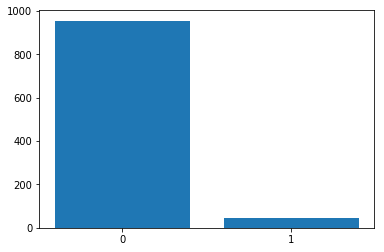

In [20]:
hist = result_new.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

In [21]:
f_1_meas = hist[0] / (hist[0] + hist[1])
f_n1_meas = hist[1] / (hist[0] + hist[1])

Y_meas = 1 * f_1_meas - 1 * f_n1_meas

M_meas = - Y_meas
M_meas

-0.9099999999999999